# 1. Reading the data

In [1]:
import pandas as pd
import re

In [2]:
r_df = pd.read_csv('data/rebtel_reviews.csv')

In [3]:
r_df['page'] = r_df['page-href'].apply(lambda x: int(re.findall('\d+', x)[0]))
r_df['rate'] = r_df['stars'].apply(lambda x: int(re.findall('\d+', x)[0]))

In [4]:
from Helper import *
helper = Helper()

r_df['processed_text'] = r_df['review_text'].apply(lambda x: helper.preprocess_text(x))
processed_df = r_df[['processed_text', 'rate', 'title']]

[nltk_data] Downloading package stopwords to /home/hamd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hamd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
r_df.head()

,page,page-href,title,review_text,stars,rate,processed_text
0,68,https://www.trustpilot.com/review/www.rebtel.c...,Brilliant service,I find this system easy to use and a way to co...,star-rating count-4 size-medium clearfix,4,find system easy use way communicate family
1,19,https://www.trustpilot.com/review/www.rebtel.c...,Not efficient customer care support,I have been using Rebtel for calling India no ...,star-rating count-2 size-medium clearfix,2,using rebtel calling india doubt call quality ...
2,90,https://www.trustpilot.com/review/www.rebtel.c...,awesome,I recently change my international calls from ...,star-rating count-5 size-medium clearfix,5,recently change international call union telec...
3,115,https://www.trustpilot.com/review/www.rebtel.c...,excellent,a huge savings for me in long distance calls,star-rating count-5 size-medium clearfix,5,huge saving long distance call
4,110,https://www.trustpilot.com/review/www.rebtel.c...,Awesome!,Great service with no hidden charges. Please q...,star-rating count-5 size-medium clearfix,5,great service hidden charge please qualify nig...


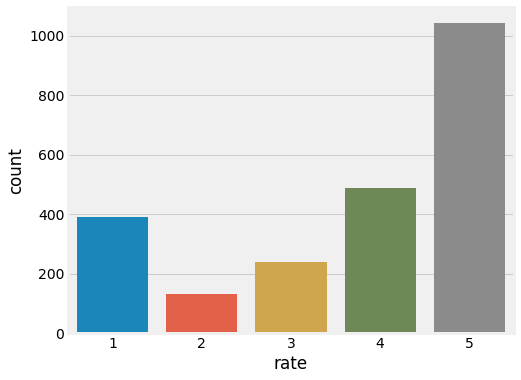

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')

sns.countplot(x='rate', data=r_df)

### Reducing to a binary classification
For now I have considered rate 3 as neutral and hence had it removed.

(I have checked this that if I do not remove rate 3, it will be the most missclassified class)

In [7]:
processed_df = processed_df[processed_df['rate'] != 3]
processed_df['pos'] = processed_df['rate'].apply(lambda x: 1 if x > 3 else 0)

### Spliting train and test

In [51]:
X = processed_df['processed_text'].values
y = processed_df['pos']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

What is the baseline for this problem?

In [9]:
print ('Baseline: ', sum(y_train)/len(y_train))

Baseline:  0.749826268242


Most of the reviews are positive. 

# 2. Classification

In the following three main approaches are considered:
<ol>
<li> Grid search over hyper parameters of linear classifiers.</li>
<li> Classification over word2vec embedding. </li>
<li> Using rating as a regression target, and then classifying input based on predicted ratings. </li>
</ol>

## 2.1 Grid Search over Hyper-parameters

In [65]:
from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report

def perform_grid_search(model, param_grid, X, y):
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=1, cv=5, scoring='f1')
    t0 = time()
    grid_search.fit(X, y)
    print("done in %0.3fs" % (time() - t0))
    return grid_search

def eval_grid(grid_res, param_grid, X, y):
    print ('Baseline: ', str(sum(y)/len(y)))
    print("Best score: %0.3f" % grid_res.best_score_)
    print("Best parameters set:")
    best_parameters = grid_res.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    print ()
    y_pred = grid_res.predict(X=X)
    print ('Confusion Matrix:')
    print (confusion_matrix(y, y_pred))
    print (accuracy_score(y, y_pred))
    print (classification_report(y, y_pred))
    

### Without downsampling

Performing a grid search over hyperparameters

In [61]:
pipeline = Pipeline([
    ('cvect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

param_grid = {
    'cvect__max_df': (0.5, 0.75, 1.0),
    #'cvect__max_features': (None, 5000, 10000, 50000),
    'cvect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'clf__loss': ('hinge', 'modified_huber', 'log'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__class_weight': (None, 'balanced'), 
#     'clf__n_iter': (100, 500, 1000)
}

In [64]:
res_gs = perform_grid_search(pipeline, param_grid, X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.0min finished


done in 118.450s


In [66]:
eval_grid(res_gs, param_grid, X_test, y_test)

Baseline:  0.736245954693
Best score: 0.945
Best parameters set:
	clf__alpha: 1e-05
	clf__class_weight: None
	clf__loss: 'log'
	clf__penalty: 'elasticnet'
	cvect__max_df: 0.75
	cvect__ngram_range: (1, 2)
	tfidf__use_idf: True

Confusion Matrix:
[[134  29]
 [ 20 435]]
0.92071197411
             precision    recall  f1-score   support

          0       0.87      0.82      0.85       163
          1       0.94      0.96      0.95       455

avg / total       0.92      0.92      0.92       618



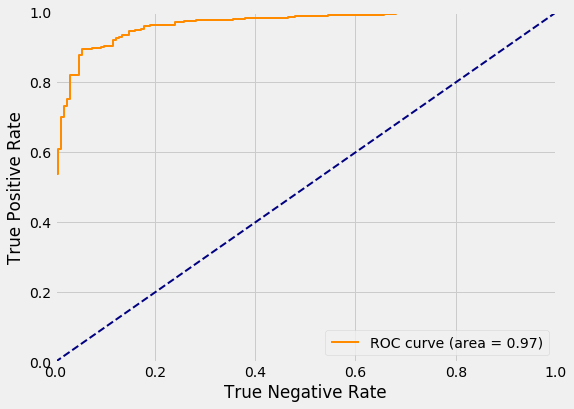

In [67]:
from sklearn.metrics import roc_curve, auc

prob_vec = res_gs.predict_proba(X_test)


fpr, tpr, thresholds = roc_curve(y_test, prob_vec[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Downsampling the larger class

Here I try to downsample the bigger class (positives), and then train the classifier on the balanced dataset. 
However, I am going to test it with the unbalanced dataset.

In [20]:
neg_indices = processed_df[processed_df['pos'] == 0].index
pos_indices = processed_df[processed_df['pos'] == 1].index[0:len(neg_indices)]

downsampled_df = processed_df.loc[neg_indices.tolist() + pos_indices.tolist()]

X_ds = downsampled_df['processed_text'].values
y_ds = downsampled_df['pos']

X_ds_train, X_ds_test, y_ds_train, y_ds_test = train_test_split(X_ds, y_ds, test_size=0.3, random_state=0)

In [21]:
print (sum(downsampled_df['pos'].values)/len(downsampled_df))

0.5


In [22]:
res_ds_gs = perform_grid_search(pipeline, param_grid, X_ds_train, y_ds_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   37.4s


done in 61.852s


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.0min finished


In [23]:
eval_grid(res_gs, param_grid, X_test, y_test)

Baseline:  0.736245954693
Best score: 0.912
Best parameters set:
	clf__alpha: 1e-05
	clf__class_weight: None
	clf__loss: 'log'
	clf__penalty: 'elasticnet'
	cvect__max_df: 0.75
	cvect__ngram_range: (1, 2)
	tfidf__use_idf: True

Confusion Matrix:
[[133  30]
 [ 19 436]]
0.92071197411
             precision    recall  f1-score   support

          0       0.88      0.82      0.84       163
          1       0.94      0.96      0.95       455

avg / total       0.92      0.92      0.92       618



## 2.2 Using word2vec

In [10]:
from w2vecModel import *
w2v_model = Word2vecModel()

In [11]:
processed_df['text_list'] = processed_df['processed_text'].apply(lambda x: x.split())
processed_df['title_list'] = processed_df['title'].apply(lambda x: x.split())

### Using an already trained model for word embeding

Download the GloVe already trained model from here: http://nlp.stanford.edu/data/glove.6B.zip

In [21]:
w2v_model.initialize('data/glove.6B/glove.6B.100d.txt')

In [32]:
X_w2v = w2v_model.transform(processed_df['text_list'], embedding='tfidf').tolist()
y = processed_df['pos']

X_w2v_train, X_w2v_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.3, random_state=0)

Obtaining the tfidf embeddings...
DIM:  100
<class 'dict'>


### Hyper parameter search

In [35]:
sgd_parameters = {
    'loss': ('hinge', 'modified_huber', 'log'),
    'alpha': (0.00001, 0.000001),
    'penalty': ('l2', 'elasticnet'),
    'class_weight': (None, 'balanced')
}

res_w2v_gs = perform_grid_search(SGDClassifier(n_iter=1000), sgd_parameters, X_w2v_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.9min finished


done in 362.760s


In [36]:
eval_grid(res_w2v_gs, sgd_parameters, X_w2v_test, y_test)

Baseline:  0.736245954693
Best score: 0.839
Best parameters set:
	alpha: 1e-06
	class_weight: None
	loss: 'modified_huber'
	penalty: 'elasticnet'

Confusion Matrix:
[[102  61]
 [ 30 425]]
0.852750809061
             precision    recall  f1-score   support

          0       0.77      0.63      0.69       163
          1       0.87      0.93      0.90       455

avg / total       0.85      0.85      0.85       618



### Using only titles instead of the full review text

This section does not improve anything. You can pass this safely! 

In [33]:
X_w2v_t = w2v_model.transform(processed_df['title_list']).tolist()
X_w2v_t_train, X_w2v_t_test, y_train, y_test = train_test_split(X_w2v_t, y, test_size=0.3, random_state=0)

Obtaining the mean embeddings...
DIM:  100


In [36]:
res_w2v_t_gs = perform_grid_search(SGDClassifier(), sgd_parameters, X_w2v_t_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
done in 2.957s


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.7s finished


In [39]:
eval_grid(res_w2v_t_gs, sgd_parameters, X_w2v_t_test, y_test)

Baseline:  0.736245954693
Best score: 0.780
Best parameters set:
	alpha: 1e-06
	class_weight: None
	loss: 'modified_huber'
	penalty: 'elasticnet'

Confusion Matrix:
[[ 91  72]
 [147 308]]
0.645631067961
             precision    recall  f1-score   support

          0       0.38      0.56      0.45       163
          1       0.81      0.68      0.74       455

avg / total       0.70      0.65      0.66       618



#### Very bad performance (no suprise though)

## 2.3 Use regression for rating as a classifier

In [37]:
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import numpy as np


def train_elastic_net(X, y):
    enet_pipeline = Pipeline([
        ('cvect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('reg', ElasticNetCV(cv=5, l1_ratio=np.arange(0.1, 1.1, .1), random_state=0, verbose=1, n_jobs=-1))
    ])

    # reg_enet = ElasticNetCV(cv=5, l1_ratio=np.arange(0, 1.1, .1), random_state=0)
    # reg_enet.fit(X_train, y_r_train)

    enet_pipeline.fit(X, y)
    return enet_pipeline

from sklearn.metrics import mean_squared_error, r2_score

def eval_regression(reg_model, X, y_true, removed_neutral=False):
    y_pred = reg_model.predict(X)
    
    print ('MSE: ', mean_squared_error(y_true, y_pred))
    print ('R2: ', r2_score(y_true, y_pred))
    
    print()
    print ('Binarized results:')
    print ('(Considering all ratings above 3 as positive, and the rest as negative,\n \
            and prediction above 2.5 as positive, and the rest as negative.)')
    y_true_b =[1 if x > 3 else 0 for x in y_true]
    y_pred_b = [1 if x > 2.5 else 0 for x in y_pred]

    print ('Baseline: ', str(sum(y_true_b)/len(y_true_b)))
    print ('Confusion Matrix:')
    print (confusion_matrix(y_true_b, y_pred_b))
    print ('Acc:')
    print (accuracy_score(y_true_b, y_pred_b))
    print (classification_report(y_true_b, y_pred_b))
    
    print ()
    print ('Considering each rating as a class: ')
    if not removed_neutral:
        y_pred_m = [5 if x > 5 else 1 if x < 1 else int(np.round(x)) for x in y_pred]
    else:
        y_pred_m = []
        for y in y_pred:
            if y < 1:
                v = 1
            elif y > 5:
                v = 5
            elif y > 2 and y < 3:
                v = 2
            elif y >= 3 and y < 4:
                v = 4
            else:
                v = int(np.round(y))
            y_pred_m.append(v)

    print ('Confusion Matrix:')
    print (confusion_matrix(y_true, y_pred_m))
    print (classification_report(y_r_test, y_pred_m))
    

### Not excluding neutral ratings (3)

Using the original dataframe in which 3 ratings are not removed.

In [38]:
X_train, X_test, y_r_train, y_r_test = helper.train_test_split(r_df, 'processed_text', 'rate')

In [39]:
e_net = train_elastic_net(X_train, y_r_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [44]:
eval_regression(e_net, X_test, y_r_test)

MSE:  1.05686776655
R2:  0.523683674027

Binarized results:
(Considering all ratings above 3 as positive, and the rest as negative,
             and prediction above 2.5 as positive, and the rest as negative.)
Baseline:  0.6574746008708273
Confusion Matrix:
[[ 93 143]
 [  4 449]]
Acc:
0.786647314949
             precision    recall  f1-score   support

          0       0.96      0.39      0.56       236
          1       0.76      0.99      0.86       453

avg / total       0.83      0.79      0.76       689


Considering each rating as a class: 
Confusion Matrix:
[[ 21  46  36  12   0]
 [  3  11  24   4   0]
 [  0  12  31  31   5]
 [  0   1  28  83  35]
 [  0   3  29 150 124]]
             precision    recall  f1-score   support

          1       0.88      0.18      0.30       115
          2       0.15      0.26      0.19        42
          3       0.21      0.39      0.27        79
          4       0.30      0.56      0.39       147
          5       0.76      0.41      0.53    

### Exclusion of neutral ratings (3)

Using the dataframe in which 3 ratings are already removed.

In [45]:
X_train, X_test, y_r_train, y_r_test = helper.train_test_split(processed_df, 'processed_text', 'rate')

In [46]:
e_net_3_removed = train_elastic_net(X_train, y_r_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [47]:
eval_regression(e_net_3_removed, X_test, y_r_test, removed_neutral=True)

MSE:  1.05943967222
R2:  0.581547208588

Binarized results:
(Considering all ratings above 3 as positive, and the rest as negative,
             and prediction above 2.5 as positive, and the rest as negative.)
Baseline:  0.7362459546925566
Confusion Matrix:
[[ 81  82]
 [  4 451]]
Acc:
0.860841423948
             precision    recall  f1-score   support

          0       0.95      0.50      0.65       163
          1       0.85      0.99      0.91       455

avg / total       0.87      0.86      0.84       618


Considering each rating as a class: 
Confusion Matrix:
[[ 31  68  25   0]
 [  1  24  13   1]
 [  1  12  75  47]
 [  0   9 149 162]]
             precision    recall  f1-score   support

          1       0.94      0.25      0.39       124
          2       0.21      0.62      0.32        39
          4       0.29      0.56      0.38       135
          5       0.77      0.51      0.61       320

avg / total       0.66      0.47      0.50       618



### Calibration of probabilities coming from regression

A well calibrated (binary) classifier should classify the samples such that among the samples for which it predicted probability close to 0.8, approximately 80% actually belong to the that class.

### Regressor classifier

This class inherits from the BaseEstimator, and uses the given regression model to fit a calssifier. 

For now any predicted rating above 2.5 is considered positive, and the rest are negative. 

I will used this class to create a calssifier with calibrated probability output.

In [47]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class RegressionClassifier(BaseEstimator, ClassifierMixin):
    '''This a wraper class around a given regression predicting rating of a given text'''
    def __init__(self, regressor):
        self.regressor = regressor
        self.classes_ = [0, 1]
        
    def fit(self, X, y):
        self.regressor.fit(X, y)
        
    def predict(self, X):
        return [1 if x > 2.5 else 0 for x in self.regressor.predict(X)]
    
    # returns predicted rating. 
    def decision_function(self, X):
        return self.regressor.predict(X)
    
    # More the rating more the probability of being positive
    def predict_proba(self, X):
        prob_pos = self.regressor.predict(X)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        return np.array([[1 - x, x] for x in prob_pos])

### Plotting the calibrated curves

In the plot below a well calibrated classifier should be close to the line y = x.

In [40]:
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# this function is mostly taken from sklearn website
def plot_calibration_curve(est, name, fig_index, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=.3, random_state=0)
    y_test =[1 if x > 3 else 0 for x in y_test]
    y_train_b = [1 if x > 3 else 0 for x in y_train]
    
    est.fit(X_train, y_train)
    
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv='prefit', method='isotonic')
    isotonic.fit(X_train, y_train_b)

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv='prefit', method='sigmoid')
    sigmoid.fit(X_train, y_train_b)
    
    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    ax1.patch.set_facecolor('None')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    ax2.patch.set_facecolor('None')
    
    plt.tight_layout()


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNet:
	Brier: 0.396
	Precision: 0.838
	Recall: 0.991
	F1: 0.908

ElasticNet + Isotonic:
	Brier: 0.736
	Precision: 0.923
	Recall: 0.949
	F1: 0.936

ElasticNet + Sigmoid:
	Brier: 0.727
	Precision: 0.916
	Recall: 0.954
	F1: 0.934



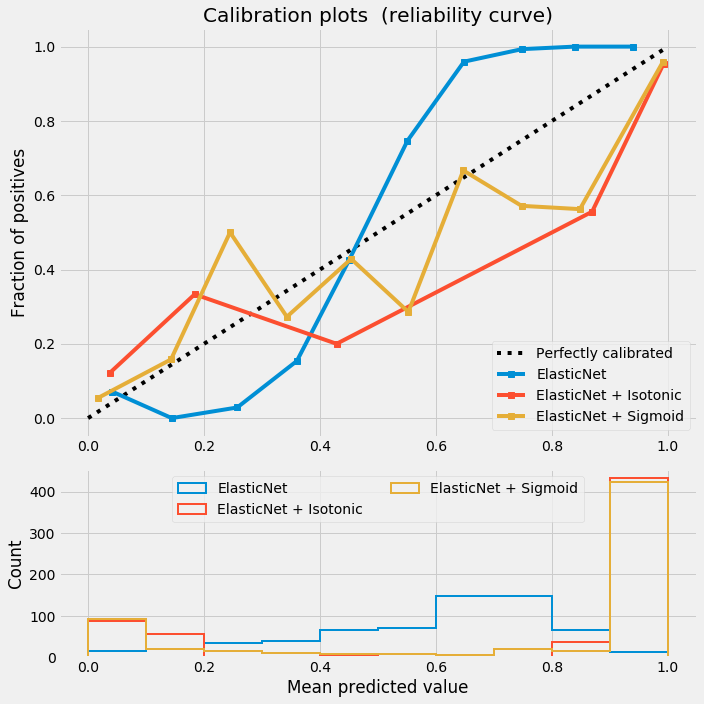

In [48]:
tfidf_pipeline = Pipeline([
    ('cvect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

X = tfidf_pipeline.fit_transform(processed_df['processed_text'].values)
y = processed_df['rate']
elastic_net = ElasticNetCV(cv=5, l1_ratio=np.arange(0.1, 1.1, .1), n_alphas=100,  random_state=0, verbose=1, n_jobs=-1)
plot_calibration_curve(RegressionClassifier(elastic_net), "ElasticNet", 1, X, y)

### Trying the calibrated model

In [52]:
def log_classification_report(y_true, y_pred):
    print ('Baseline: ', str(sum(y_true)/len(y_true)))
    print ('Confusion Matrix:')
    print (confusion_matrix(y_true, y_pred))
    print ('Acc:')
    print (accuracy_score(y_true, y_pred))
    print (classification_report(y_true, y_pred))

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=.3, random_state=0)

y_test_b =[1 if x > 3 else 0 for x in y_test]
y_train_b = [1 if x > 3 else 0 for x in y_train]

enet = ElasticNetCV(cv=5, l1_ratio=np.arange(0.1, 1.1, .1), random_state=0, verbose=1, n_jobs=-1)
enet_reg = RegressionClassifier(enet)

enet_reg.fit(X_train, y_train)



........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [53]:
y_pred = enet_reg.predict(X_test)
print ('Naive threshod regression results:')
log_classification_report(y_test_b, y_pred)

sigmoid = CalibratedClassifierCV(enet_reg, cv='prefit', method='sigmoid')
sigmoid.fit(X_train, y_train_b)
y_pred = sigmoid.predict(X_test)
print ()
print ('Sigmoid calibration results:')
log_classification_report(y_test_b, y_pred)

isotonic = CalibratedClassifierCV(enet_reg, cv='prefit', method='isotonic')
isotonic.fit(X_train, y_train_b)
y_pred = sigmoid.predict(X_test)
print ()
print ('Isotonic calibration results:')
log_classification_report(y_test_b, y_pred)

Naive threshod regression results:
Sigmoid results:
Baseline:  0.7362459546925566
Confusion Matrix:
[[ 76  87]
 [  4 451]]
Acc:
0.852750809061
             precision    recall  f1-score   support

          0       0.95      0.47      0.63       163
          1       0.84      0.99      0.91       455

avg / total       0.87      0.85      0.83       618


Sigmoid calibration results:
Sigmoid results:
Baseline:  0.7362459546925566
Confusion Matrix:
[[123  40]
 [ 21 434]]
Acc:
0.901294498382
             precision    recall  f1-score   support

          0       0.85      0.75      0.80       163
          1       0.92      0.95      0.93       455

avg / total       0.90      0.90      0.90       618


Isotonic calibration results:
Sigmoid results:
Baseline:  0.7362459546925566
Confusion Matrix:
[[123  40]
 [ 21 434]]
Acc:
0.901294498382
             precision    recall  f1-score   support

          0       0.85      0.75      0.80       163
          1       0.92      0.95      0.93 

The results are imporoved comparing with previouse naive threshold regression method. However, still it is not bitting the first tried method (grid search over linear classifiers).